<a href="https://colab.research.google.com/github/sdamians/taller-explicabilidad/blob/main/practica_1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://evcccpln.cscoglab.com/wp-content/uploads/2024/01/logo.webp" height=100 witdh=100/>

## EVCCCPLN Segunda Edición
#### PROFUNDIZANDO EN EL CONOCIMIENTO: MÉTODOS PARA EXPLICAR LOS MODELOS DE LENGUAJE

Practica 1.2 - Modelo BETO para predecir si una oración es misógina y explicando el comportamiento del modelo con SHAP

In [ ]:
%%capture
!pip install transformers[torch]

In [ ]:
%%capture
!pip install datasets

In [ ]:
%%capture
!pip install shap

In [ ]:
import torch
import numpy as np
import pandas as pd

from datasets import load_dataset
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import AutoTokenizer
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

pd.set_option('display.max_colwidth', None)

In [ ]:
raw_dataset   = load_dataset("glombardo/misogynistic-statements-classification")
TEXT_COLNAME  = 'text'
LABEL_COLNAME = 'label'
LABELS = ['No Misógino', 'Misógino']
RANDOM_STATE = 43

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/127 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/42 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/43 [00:00<?, ? examples/s]

### Version 1

In [ ]:
modelname = "dccuchile/bert-base-spanish-wwm-cased"
tokenizer = AutoTokenizer.from_pretrained(modelname)
model = AutoModelForSequenceClassification.from_pretrained(modelname, num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples[TEXT_COLNAME],
                                 is_split_into_words = False,
                                 truncation          = True,
                                 max_length          = 64,
                                 padding             = 'max_length')

    return tokenized_inputs

In [ ]:
tokenized_dataset = raw_dataset.map(
    tokenize_and_align_labels,
    batched        = True,
    batch_size     = 8
    )

Map:   0%|          | 0/127 [00:00<?, ? examples/s]

Map:   0%|          | 0/42 [00:00<?, ? examples/s]

Map:   0%|          | 0/43 [00:00<?, ? examples/s]

In [ ]:
train_df = pd.DataFrame(tokenized_dataset['train'])
test_df = pd.DataFrame(tokenized_dataset['test'])
train_df[ [TEXT_COLNAME, LABEL_COLNAME] ].head(10)

text  \
0                                                                                      Los hombres son mejores en deportes   
1        Las mujeres tienen las mismas capacidades físicas y mentales que los hombres para participar en deportes extremos   
2                                               Cualquier persona puede cuidar de sí misma independientemente de su género   
3                                                               Las mujeres son demasiado delicadas para trabajos manuales   
4                                                  Las mujeres son demasiado emocionales para tomar decisiones importantes   
5                  La habilidad para el combate no depende del género y todas las personas pueden ser igualmente valientes   
6                                                                                        Las mujeres no pueden ser líderes   
7   El deporte es una actividad personal y el interés no depende del género sino de las preferencias y gustos individuales   
8                                           Las mujeres son irracionales y están demasiado influenciadas por sus emociones   
9                                                                               Las mujeres no son buenas para la política   

   label  
0      1  
1      0  
2      0  
3      1  
4      1  
5      0  
6      1  
7      0  
8      1  
9      1

In [ ]:
#import evaluate
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

def sigmoid(x):
    return (1 / (1 + np.exp(-x))).tolist()

def compute_metrics(pred):
  logits, labels = pred
  preds = np.argmax(logits, axis=-1)

  # Calculate precision, recall, and F1 score for each label
  precision = precision_score(labels, preds, average=None, zero_division=0.0)
  recall    = recall_score(labels, preds, average=None, zero_division=0.0)
  f1        = f1_score(labels, preds, average=None, zero_division=0.0)

  # Calculate macro-averaged precision, recall, and F1 score
  macro_precision = np.mean(precision)
  macro_recall    = np.mean(recall)
  macro_f1        = np.mean(f1)

  print(classification_report(y_true=labels, y_pred=preds, target_names=LABELS, digits=4, zero_division=0.0))

  return {
      "macro_precision": macro_precision,
      "macro_recall": macro_recall,
      "macro_f1": macro_f1
  }

In [ ]:
from torch.nn import CrossEntropyLoss

class MultiLabelNERTrainer(Trainer):
    def __init__(self, *args, class_weights = None, **kwargs):
      super().__init__(*args, **kwargs)

      if class_weights is not None:
        class_weights = class_weights.to(self.args.device)
        print("class weights implemented")
      self.loss_fct = CrossEntropyLoss(weight = class_weights)

    def compute_loss(self, model, inputs, return_outputs=False):
      """
      How the loss is computed by Trainer.
      By default, all models return the loss in the first element.
      Subclass and override for custom behavior.
      """
      labels  = inputs.pop("labels")
      outputs = model(**inputs)

      loss = self.loss_fct(outputs.logits, labels)

      return (loss, outputs) if return_outputs else loss

In [ ]:
from transformers.optimization import SchedulerType

training_args = TrainingArguments(
    output_dir                  = "drive/MyDrive/datasets/results",
    eval_strategy               = "epoch",
    learning_rate               = 4e-5,
    num_train_epochs            = 5,
    weight_decay                = 0,
    seed                        = 43,
    save_strategy               = 'no',
    load_best_model_at_end      = False,
    metric_for_best_model       = "macro_f1",
    greater_is_better           = True,
    save_total_limit            = 1,
    gradient_accumulation_steps = 2,
    per_device_eval_batch_size  = 8,
    per_device_train_batch_size = 8,
    lr_scheduler_type = SchedulerType.POLYNOMIAL
    )

trainer = MultiLabelNERTrainer(
    model           = model,
    args            = training_args,
    train_dataset   = tokenized_dataset["train"],
    eval_dataset    = tokenized_dataset["validation"],
    tokenizer       = tokenizer,
    compute_metrics = compute_metrics,
    #class_weights   = class_weights
    )

In [ ]:
trainer.train()

              precision    recall  f1-score   support

 No Misógino     0.8095    0.9444    0.8718        18
    Misógino     0.9524    0.8333    0.8889        24

    accuracy                         0.8810        42
   macro avg     0.8810    0.8889    0.8803        42
weighted avg     0.8912    0.8810    0.8816        42

              precision    recall  f1-score   support

 No Misógino     0.9000    1.0000    0.9474        18
    Misógino     1.0000    0.9167    0.9565        24

    accuracy                         0.9524        42
   macro avg     0.9500    0.9583    0.9519        42
weighted avg     0.9571    0.9524    0.9526        42

              precision    recall  f1-score   support

 No Misógino     0.8571    1.0000    0.9231        18
    Misógino     1.0000    0.8750    0.9333        24

    accuracy                         0.9286        42
   macro avg     0.9286    0.9375    0.9282        42
weighted avg     0.9388    0.9286    0.9289        42

              preci

TrainOutput(global_step=40, training_loss=0.11844711303710938, metrics={'train_runtime': 11.6677, 'train_samples_per_second': 54.424, 'train_steps_per_second': 3.428, 'total_flos': 20884440019200.0, 'train_loss': 0.11844711303710938, 'epoch': 5.0})

In [ ]:
from google.colab import drive
drive.mount('/content/drive1', force_remount = True)

Mounted at /content/drive1


In [ ]:
modelpath = "drive1/MyDrive/datasets/results/misoginia/" + modelname

In [ ]:
trainer.save_model(modelpath)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(modelpath)
model = AutoModelForSequenceClassification.from_pretrained(modelpath, num_labels=2)
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
from sklearn.metrics import classification_report

def evaluate_test(model, test_dataset, batch_size=8, target_names=None):
    with torch.no_grad():
        final_predictions = []
        final_labels = []

        for i in range(0, len(test_dataset), batch_size):
            batch = test_dataset[i:i+batch_size]

            # Move tensors to the appropriate device
            inputs = {k: torch.tensor(v).cuda() for k, v in batch.items() if k in ['input_ids', 'attention_mask']}
            labels = torch.tensor(batch['label']).cuda()

            # Forward pass
            outputs = model(**inputs, labels=labels)

            # Calculate loss
            #loss = outputs.loss
            #total_loss += loss.item()

            # Get predictions
            predictions = torch.argmax(outputs.logits, dim=-1)
            final_predictions.extend(predictions.to('cpu'))
            final_labels.extend(labels.to('cpu'))

        # Compute final metrics
        print(classification_report(y_true=final_labels, y_pred=final_predictions, target_names=target_names, digits=4, zero_division=0.0))

In [ ]:
evaluate_test(model, tokenized_dataset["test"], target_names=LABELS)

              precision    recall  f1-score   support

 No Misógino     0.9583    1.0000    0.9787        23
    Misógino     1.0000    0.9500    0.9744        20

    accuracy                         0.9767        43
   macro avg     0.9792    0.9750    0.9765        43
weighted avg     0.9777    0.9767    0.9767        43



#### SHAP

In [ ]:
import shap

In [ ]:
import re

def f(x):
    x = list(x)
    #x = [ re.sub(r'\s+', ' ', re.sub(r'(\[MASK\])', r' \1 ', elem)).strip() for elem in x ]
    x = [ re.sub(r'\s+', ' ', re.sub(r'(\[MASK\])', r'', elem)).strip() for elem in x ]
    #print(x)
    inputs = tokenizer(list(x),
                      is_split_into_words = False,
                      truncation          = True,
                      max_length          = 64,
                      padding             = 'max_length')

    inputs = {k: torch.tensor(v).cuda() for k, v in inputs.items() if k in ['input_ids', 'attention_mask']}

    outputs = model( **inputs )[0].detach()
    outputs = torch.nn.Softmax(-1)(outputs)

    return outputs[:,1]

In [ ]:
explainer = shap.Explainer(f, tokenizer, seed=43)

In [ ]:
shap_values = explainer(tokenized_dataset["test"][TEXT_COLNAME], fixed_context=None, max_evals=1000)

PartitionExplainer explainer: 44it [00:52,  1.51s/it]


Summary plot

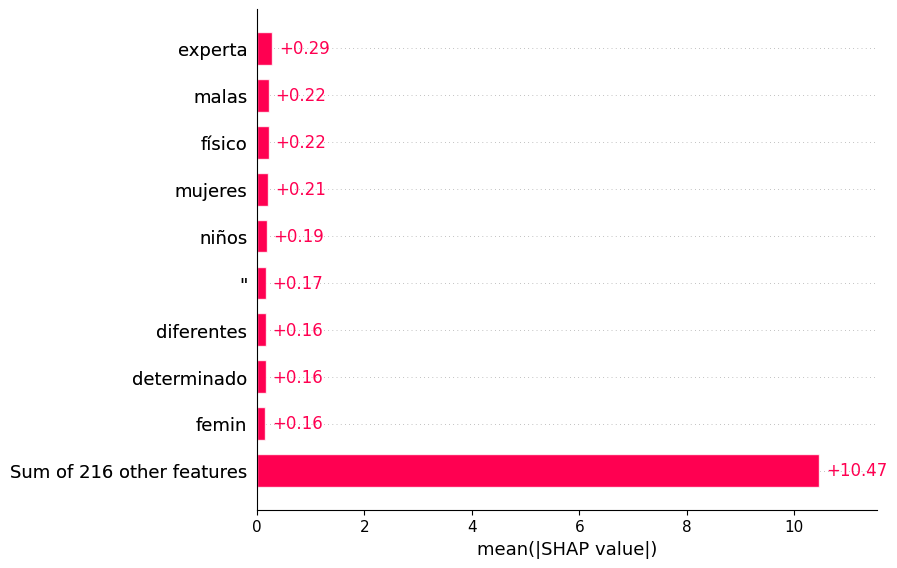

In [ ]:
shap.plots.bar(shap_values)

In [ ]:
shap.plots.text(shap_values)

Predicción individual A

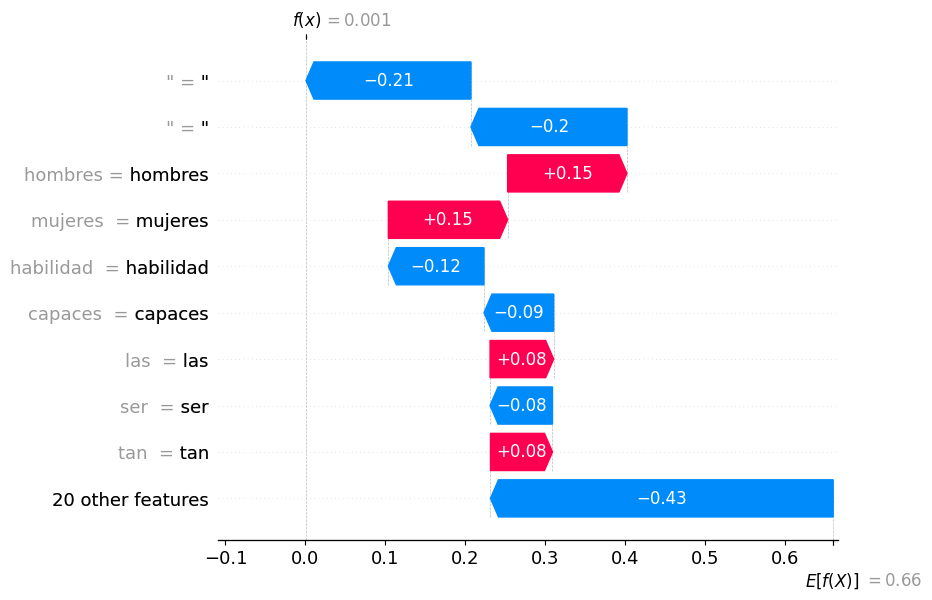

In [ ]:
shap.initjs()
ind = 3
shap.plots.waterfall(shap_values[ind], max_display=10)

In [ ]:
print(test_df[TEXT_COLNAME].iloc[ind])
print(test_df[LABEL_COLNAME].iloc[ind])

 "La habilidad de manejar el estrés no depende del género y las mujeres pueden ser tan capaces y resilientes como los hombres"
0


### Version 2

In [ ]:
modelname = "dccuchile/bert-base-spanish-wwm-cased"
tokenizer = AutoTokenizer.from_pretrained(modelname)
model = AutoModelForSequenceClassification.from_pretrained(modelname, num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import re

def tokenize_and_align_labels(examples):
    examples[TEXT_COLNAME] = [ re.sub(r'[¿\?,"]', '', example)  for example in examples[TEXT_COLNAME] ]
    tokenized_inputs = tokenizer(examples[TEXT_COLNAME],
                                 is_split_into_words = False,
                                 truncation          = True,
                                 max_length          = 64,
                                 padding             = 'max_length')

    return tokenized_inputs

In [ ]:
tokenized_dataset = raw_dataset.map(
    tokenize_and_align_labels,
    batched        = True,
    batch_size     = 8
    )

Map:   0%|          | 0/42 [00:00<?, ? examples/s]

In [ ]:
train_df = pd.DataFrame(tokenized_dataset['train'])
test_df = pd.DataFrame(tokenized_dataset['test'])
train_df[ [TEXT_COLNAME, LABEL_COLNAME] ].head(10)

text  \
0                                                                                      Los hombres son mejores en deportes   
1        Las mujeres tienen las mismas capacidades físicas y mentales que los hombres para participar en deportes extremos   
2                                               Cualquier persona puede cuidar de sí misma independientemente de su género   
3                                                               Las mujeres son demasiado delicadas para trabajos manuales   
4                                                  Las mujeres son demasiado emocionales para tomar decisiones importantes   
5                  La habilidad para el combate no depende del género y todas las personas pueden ser igualmente valientes   
6                                                                                        Las mujeres no pueden ser líderes   
7   El deporte es una actividad personal y el interés no depende del género sino de las preferencias y gustos individuales   
8                                           Las mujeres son irracionales y están demasiado influenciadas por sus emociones   
9                                                                               Las mujeres no son buenas para la política   

   label  
0      1  
1      0  
2      0  
3      1  
4      1  
5      0  
6      1  
7      0  
8      1  
9      1

In [ ]:
#import evaluate
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

def sigmoid(x):
    return (1 / (1 + np.exp(-x))).tolist()

def compute_metrics(pred):
  logits, labels = pred
  preds = np.argmax(logits, axis=-1)

  # Calculate precision, recall, and F1 score for each label
  precision = precision_score(labels, preds, average=None, zero_division=0.0)
  recall    = recall_score(labels, preds, average=None, zero_division=0.0)
  f1        = f1_score(labels, preds, average=None, zero_division=0.0)

  # Calculate macro-averaged precision, recall, and F1 score
  macro_precision = np.mean(precision)
  macro_recall    = np.mean(recall)
  macro_f1        = np.mean(f1)

  print(classification_report(y_true=labels, y_pred=preds, target_names=LABELS, digits=4, zero_division=0.0))

  return {
      "macro_precision": macro_precision,
      "macro_recall": macro_recall,
      "macro_f1": macro_f1
  }

In [ ]:
from torch.nn import CrossEntropyLoss

class MultiLabelNERTrainer(Trainer):
    def __init__(self, *args, class_weights = None, **kwargs):
      super().__init__(*args, **kwargs)

      if class_weights is not None:
        class_weights = class_weights.to(self.args.device)
        print("class weights implemented")
      self.loss_fct = CrossEntropyLoss(weight = class_weights)

    def compute_loss(self, model, inputs, return_outputs=False):
      """
      How the loss is computed by Trainer.
      By default, all models return the loss in the first element.
      Subclass and override for custom behavior.
      """
      labels  = inputs.pop("labels")
      outputs = model(**inputs)

      loss = self.loss_fct(outputs.logits, labels)

      return (loss, outputs) if return_outputs else loss

In [ ]:
from transformers.optimization import SchedulerType

training_args = TrainingArguments(
    output_dir                  = "drive/MyDrive/datasets/results",
    eval_strategy               = "epoch",
    learning_rate               = 4e-5,
    num_train_epochs            = 5,
    weight_decay                = 0,
    seed                        = 43,
    save_strategy               = 'no',
    load_best_model_at_end      = False,
    metric_for_best_model       = "macro_f1",
    greater_is_better           = True,
    save_total_limit            = 1,
    gradient_accumulation_steps = 2,
    per_device_eval_batch_size  = 8,
    per_device_train_batch_size = 8,
    lr_scheduler_type = SchedulerType.POLYNOMIAL
    )

trainer = MultiLabelNERTrainer(
    model           = model,
    args            = training_args,
    train_dataset   = tokenized_dataset["train"],
    eval_dataset    = tokenized_dataset["validation"],
    tokenizer       = tokenizer,
    compute_metrics = compute_metrics,
    #class_weights   = class_weights
    )

In [ ]:
trainer.train()

              precision    recall  f1-score   support

 No Misógino     0.8095    0.9444    0.8718        18
    Misógino     0.9524    0.8333    0.8889        24

    accuracy                         0.8810        42
   macro avg     0.8810    0.8889    0.8803        42
weighted avg     0.8912    0.8810    0.8816        42

              precision    recall  f1-score   support

 No Misógino     0.9000    1.0000    0.9474        18
    Misógino     1.0000    0.9167    0.9565        24

    accuracy                         0.9524        42
   macro avg     0.9500    0.9583    0.9519        42
weighted avg     0.9571    0.9524    0.9526        42

              precision    recall  f1-score   support

 No Misógino     0.8571    1.0000    0.9231        18
    Misógino     1.0000    0.8750    0.9333        24

    accuracy                         0.9286        42
   macro avg     0.9286    0.9375    0.9282        42
weighted avg     0.9388    0.9286    0.9289        42

              preci

TrainOutput(global_step=40, training_loss=0.11844711303710938, metrics={'train_runtime': 11.6268, 'train_samples_per_second': 54.615, 'train_steps_per_second': 3.44, 'total_flos': 20884440019200.0, 'train_loss': 0.11844711303710938, 'epoch': 5.0})

In [ ]:
from google.colab import drive
drive.mount('/content/drive1', force_remount = True)

Mounted at /content/drive1


In [ ]:
modelpath = "drive1/MyDrive/datasets/results/misoginia/" + modelname

In [ ]:
trainer.save_model(modelpath)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(modelpath)
model = AutoModelForSequenceClassification.from_pretrained(modelpath, num_labels=2)
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
from sklearn.metrics import classification_report

def evaluate_test(model, test_dataset, batch_size=8, target_names=None):
    with torch.no_grad():
        final_predictions = []
        final_labels = []

        for i in range(0, len(test_dataset), batch_size):
            batch = test_dataset[i:i+batch_size]

            # Move tensors to the appropriate device
            inputs = {k: torch.tensor(v).cuda() for k, v in batch.items() if k in ['input_ids', 'attention_mask']}
            labels = torch.tensor(batch['label']).cuda()

            # Forward pass
            outputs = model(**inputs, labels=labels)

            # Calculate loss
            #loss = outputs.loss
            #total_loss += loss.item()

            # Get predictions
            predictions = torch.argmax(outputs.logits, dim=-1)
            final_predictions.extend(predictions.to('cpu'))
            final_labels.extend(labels.to('cpu'))

        # Compute final metrics
        print(classification_report(y_true=final_labels, y_pred=final_predictions, target_names=target_names, digits=4, zero_division=0.0))
        return final_labels, final_predictions

In [ ]:
y_target, y_pred = evaluate_test(model, tokenized_dataset["test"], target_names=LABELS)

              precision    recall  f1-score   support

 No Misógino     0.9583    1.0000    0.9787        23
    Misógino     1.0000    0.9500    0.9744        20

    accuracy                         0.9767        43
   macro avg     0.9792    0.9750    0.9765        43
weighted avg     0.9777    0.9767    0.9767        43



In [ ]:
wrong_preds_idx = [ idx for idx, y in enumerate(zip(y_target, y_pred)) if y[0] != y[1]]
wrong_preds_idx

[40]

#### SHAP

In [ ]:
import shap

In [ ]:
import re

def f(x):
    x = list(x)
    #x = [ re.sub(r'\s+', ' ', re.sub(r'(\[MASK\])', r' \1 ', elem)).strip() for elem in x ]
    x = [ re.sub(r'\s+', ' ', re.sub(r'(\[MASK\])', r'', elem)).strip() for elem in x ]
    #print(x)
    inputs = tokenizer(list(x),
                      is_split_into_words = False,
                      truncation          = True,
                      max_length          = 64,
                      padding             = 'max_length')

    inputs = {k: torch.tensor(v).cuda() for k, v in inputs.items() if k in ['input_ids', 'attention_mask']}

    outputs = model( **inputs )[0].detach()
    outputs = torch.nn.Softmax(-1)(outputs)

    return outputs[:,1]

In [ ]:
explainer = shap.Explainer(f, tokenizer, seed=43)

In [ ]:
shap_values = explainer(tokenized_dataset["test"][TEXT_COLNAME], fixed_context=None, max_evals=1000)

PartitionExplainer explainer:  51%|█████     | 22/43 [00:33<00:38,  1.86s/it]

  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 44it [00:58,  1.68s/it]


Summary plot

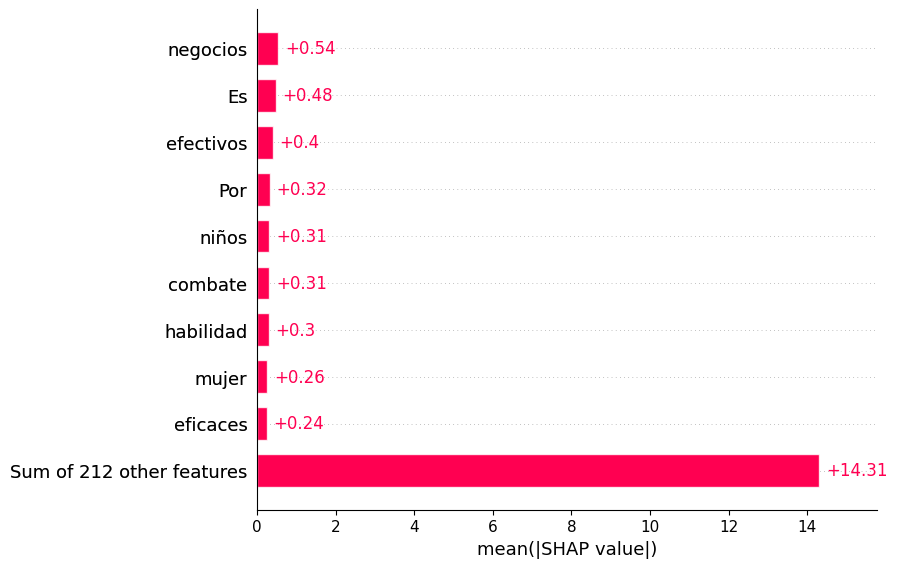

In [ ]:
shap.plots.bar(shap_values)

In [ ]:
shap.plots.text(shap_values)

Predicción individual A

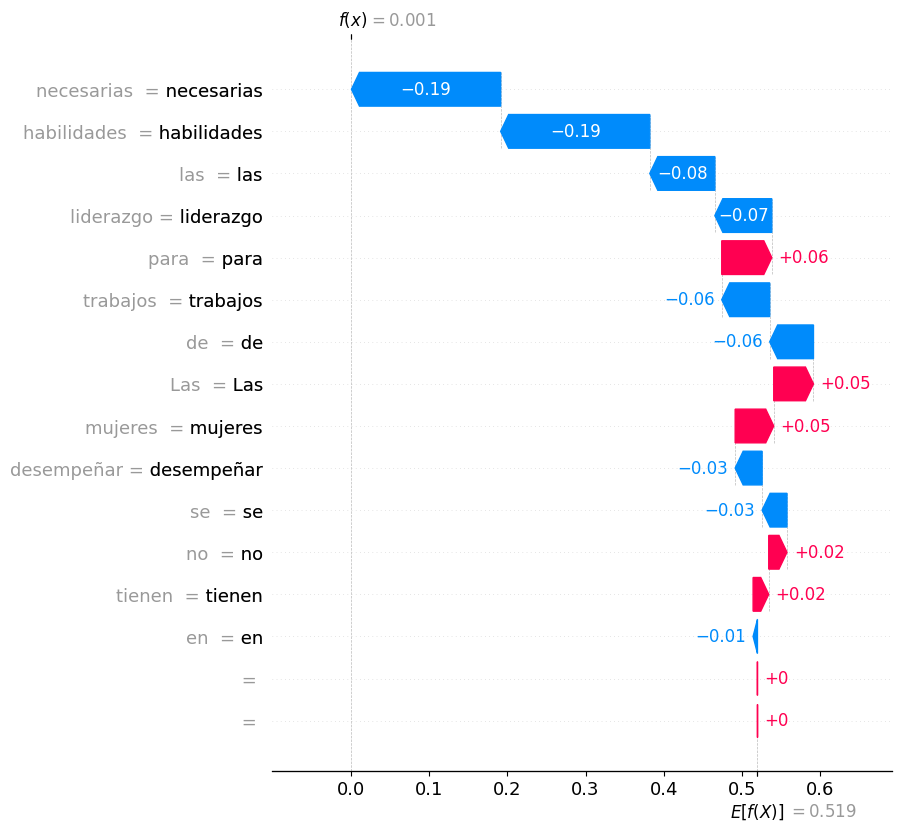

In [ ]:
shap.initjs()
ind = 40
shap.plots.waterfall(shap_values[ind], max_display=20)

In [ ]:
print(test_df[TEXT_COLNAME].iloc[ind])
print(test_df[LABEL_COLNAME].iloc[ind])

Las mujeres no tienen las habilidades necesarias para desempeñarse en trabajos de liderazgo
1
